# State Schema

## Review

Goals

Building a deeper understanding of both state and memory.

## Schema

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

All nodes are expected to communicate with that schema.

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!


In [1]:
from typing_extensions import TypedDict
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal['happy', 'sad']

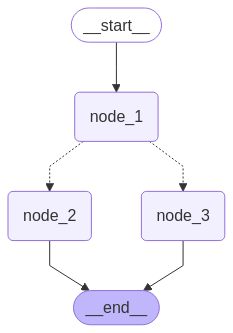

In [4]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:

    if random.random() < 0.5:
        return "node_2"
    
    return "node_3"

#Builder graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
graph.invoke({'name': "Raahul"})

---Node 1---
---Node 2---


{'name': 'Raahul is ... ', 'mood': 'happy'}

## Dataclass

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

In [6]:
from dataclasses import dataclass

@dataclass
class DataClassState:
    name: str
    mood: Literal["happy", "sad"]

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`: 

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.
 
This is possible because LangGraph stores each key of your state object separately.

The object returned by the node only needs to have keys (attributes) that match those in the state!

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

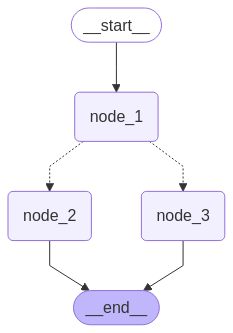

In [8]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ..."}

# Build graph
builder = StateGraph(DataClassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [12]:
graph.invoke(DataClassState(name="Raahul", mood="mad"))

---Node 1---
---Node 2---


{'name': 'Raahul is ...', 'mood': 'happy'}

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

In [17]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str

    @field_validator('mood')
    @classmethod

    def validate_mood(cls, value):
        if value not in ['happy', 'sad']:
            raise ValidationError("Each mood must be 'happy' or 'sad'")
        return value
    
try:
    state = PydanticState(name="Raahul", mood='sad')
except ValidationError as e:
    print("ValidationError:", e)

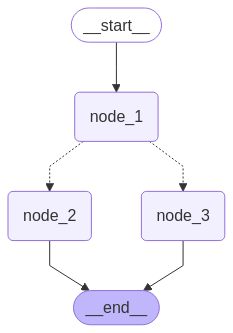

In [18]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Change the mood to anything other than happy or sad.

In [23]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ...', 'mood': 'happy'}

# State Reducers

Goals
- Dive into reducers, which specify how State updates are performed on specififc keys / channels in the state schema

## Default - Overwriting State

Branching

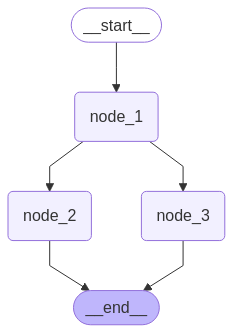

In [4]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo']+1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo']+1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo']+1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo":1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occured: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occured: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function. 

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

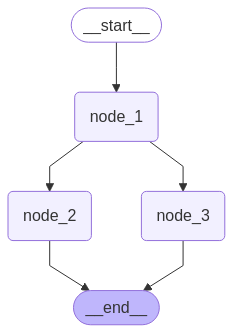

In [11]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo : Annotated[list[int], add]

def node_1(state):
    print("---Node 1")
    return {'foo': [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2")
    return {'foo': [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3")
    return {'foo': [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [12]:
graph.invoke({'foo':[1]})

---Node 1
---Node 2
---Node 3


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`. 

In [13]:
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypedError occurred: {e}")

TypedError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

In [15]:
def reduce_list(left:list|None, right: list|None)-> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """

    if not left:
        left = []
    if not right:
        right = []
    
    return left+right

class DefaultState(TypedDict):
    foo : Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo : Annotated[list[int], reduce_list]

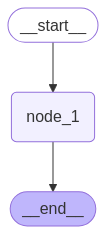

TypeError occurred: can only concatenate list (not "NoneType") to list


In [16]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Lets, try using our custom reducer. We can see that no error is thrown.

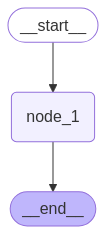

---Node 1---
{'foo': [2]}


In [18]:
# Builder graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

try:
    print(graph.invoke({"foo":None}))
except TypeError as e:
    print(f"TypeError occured: {e}")

## Messages

Re-writng

If we pass a message with the sameID as an exisiting one in our `messages` list, `add_messages` reducer will overwrite it

In [19]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on CHennai Super Kings.", name="Raahul", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on MS Dhoni, specifically", name="Raahul", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on MS Dhoni, specifically", additional_kwargs={}, response_metadata={}, name='Raahul', id='2')]

Removal

`add_messages` also enables message removal.

In [24]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Raahul", id="2"))
messages.append(AIMessage("So you said you were intrested on IPL", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I just started following IPL, tell me more about this league", name="Raahul", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[0:2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [25]:
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were intrested on IPL', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I just started following IPL, tell me more about this league', additional_kwargs={}, response_metadata={}, name='Raahul', id='4')]